## Example of AnnDataLoader usage for integration with supervised CVAE

In [1]:
import gdown

import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist

import numpy as np
import scanpy as sc

from anndata.dev.pytorch import AnnDataLoader
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)
    
    def forward(self, *inputs):
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

<img src="sup_cvae.jpg" width="50%" height="50%">

In [3]:
# The code is based on the scarches trvae model
# https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
# and on the pyro.ai Variational Autoencoders tutorial
# http://pyro.ai/examples/vae.html
class CVAE(nn.Module):
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = nn.Linear(latent_dim, n_classes)
        
        self.latent_dim = latent_dim
    
    def model(self, x, batches, classes, size_factors):
        pyro.module("decoder", self.decoder)
        pyro.module("theta", self.theta)
        pyro.module("classifier", self.classifier)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            pyro.sample("class", dist.Categorical(probs=classes_probs), obs=classes)
            
            dec_mu = self.decoder(z, batches).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("obs", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
    
    def guide(self, x, batches, classes, size_factors):
        pyro.module("encoder", self.encoder)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            pyro.sample("latent", dist.Normal(z_mu, z_var).to_event(1))

In [ ]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

In [5]:
adata = sc.read('pancreas.h5ad')

In [6]:
adata.X = adata.raw.X

In [7]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


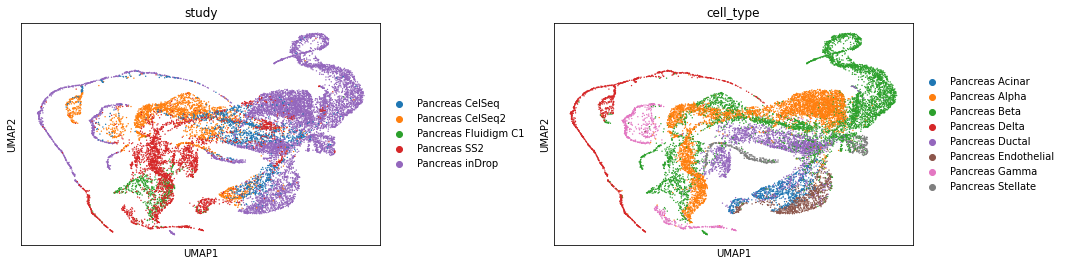

In [8]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

In [9]:
adata.obs['size_factors'] = adata.X.sum(1)

In [10]:
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc.fit(adata.obs['study'].to_numpy()[: , None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [11]:
enc_ct = LabelEncoder()
enc_ct.fit(adata.obs['cell_type'])

LabelEncoder()

In [12]:
use_cuda = torch.cuda.is_available()

convert = {'obs':
           {'study': lambda s: enc.transform(s.to_numpy()[: , None]),
            'cell_type': lambda c: enc_ct.transform(c)
           }
          }

dataloader = AnnDataLoader(adata, batch_size=128, shuffle=True, convert=convert, use_cuda=use_cuda)

In [13]:
n_conds = len(adata.obs['study'].cat.categories)
n_classes = len(adata.obs['cell_type'].cat.categories)
cvae = CVAE(adata.n_vars, n_conds=n_conds, n_classes=n_classes, hidden_dims=[128, 128], latent_dim=10)

if use_cuda:
    cvae.cuda()

In [14]:
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(cvae.model, cvae.guide, optimizer, loss=pyro.infer.TraceMeanField_ELBO())

In [15]:
def train(svi, train_loader):
    epoch_loss = 0.
    for batch in train_loader:
        epoch_loss += svi.step(batch.X, batch.obs['study'], batch.obs['cell_type'], batch.obs['size_factors'])

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [16]:
NUM_EPOCHS = 210

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, dataloader)
    if epoch % 40 == 0:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 1230.7238
[epoch 040]  average training loss: 697.7664
[epoch 080]  average training loss: 687.6127
[epoch 120]  average training loss: 684.2370
[epoch 160]  average training loss: 682.3273
[epoch 200]  average training loss: 681.0168


In [17]:
full_data = dataloader.dataset[:]

In [18]:
latents = cvae.encoder(full_data.X, full_data.obs['study'])[:, :10]

In [19]:
adata.obsm['X_cvae'] = latents.data.cpu().numpy()

In [20]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

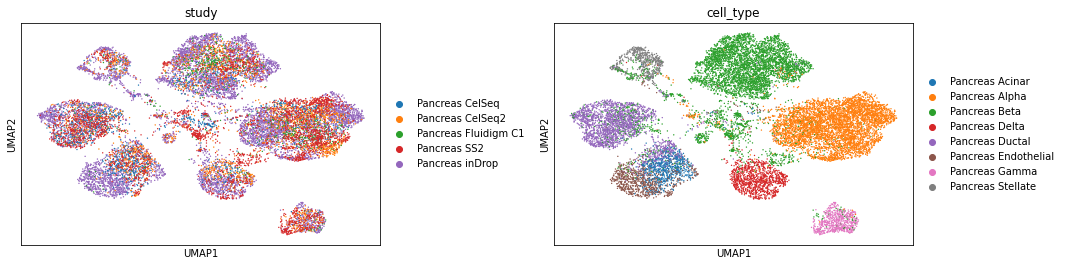

In [21]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.35)

In [22]:
accuracy = (cvae.classifier(latents).argmax(dim=-1)==full_data.obs['cell_type']).sum().item()/adata.n_obs

In [23]:
accuracy

0.9232829538932465